

# Skill 6: Face Pose Estimation
# Nadeer Hasan
# PSRS-UPEC

# Setup


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.7 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

# Navigate to the dataset directory
import os


# Corrected path to your dataset
dataset_path = '/content/drive/My Drive/AFLW2000-3D/AFLW2000'

# Check if the path exists
if os.path.exists(dataset_path):
    print(f"Dataset directory exists: {dataset_path}")
else:
    print(f"Dataset directory not found: {dataset_path}")



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Dataset directory exists: /content/drive/My Drive/AFLW2000-3D/AFLW2000


#  Loading Data:

In [ ]:
poses_df = pd.read_csv('/content/poses.csv')
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


In [ ]:
poses_df = poses_df.dropna(axis=0)
poses_df.shape

(1792, 17)

#  Preprocessing:

In [ ]:
def normalize(poses_df):
    normalized_df = poses_df.copy()

    for dim in ['x', 'y']:
        # Centerning around the nose
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]


        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff

    return normalized_df

In [ ]:
poses_df = normalize(poses_df)
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.0,0.0,-0.069582,-1.516075,-0.835918,-0.675221,-0.497313,0.355848,-0.156862,0.798616,0.459186,-0.690928,0.164082,0.324779,-0.306358,-0.283822,0.038554
1992,0.0,0.0,-0.034515,-1.424327,-0.886287,-0.717177,-0.613809,0.292342,-0.229223,0.765727,0.467706,-0.711614,0.113713,0.282823,-0.367547,-0.429723,0.122791
1994,0.0,0.0,0.424978,-1.002710,-0.711851,-0.594513,-0.683567,0.258108,-0.404571,0.692207,0.930189,-0.319230,0.288149,0.405487,-0.156035,0.567114,-0.108536
1995,0.0,0.0,0.170664,-1.239908,-0.620394,-0.700198,-0.348568,0.218915,-0.016775,0.625044,0.910883,-0.509458,0.379606,0.299802,-0.197102,-0.070430,0.105118


In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)


X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]
print(X_train.shape, y_train.shape)

(1433, 14) (1433, 3)


# Machine Learning Stuff


###  Support Vector Regressor:

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val))))

best parameters:  {'estimator__C': 2.3463404498842957, 'estimator__coef0': 4, 'estimator__degree': 4, 'estimator__epsilon': 0.13167456935454494, 'estimator__gamma': 0.09129425537759533, 'estimator__kernel': 'rbf'}
train_rmse:  0.22580119825259934
validation_rmse:  0.1884249528604136


### `b)` Desicion Tree Regressor:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}

reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_grid, scoring='neg_mean_squared_error', n_iter=40)
random_search.fit(X_train, y_train)
tree_model = random_search.best_estimator_

print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, tree_model.predict(X_val))))

best parameters:  {'estimator__ccp_alpha': 0.0008166841202939551, 'estimator__max_depth': 8, 'estimator__max_features': 7, 'estimator__min_samples_leaf': 64, 'estimator__min_samples_split': 128}
train_rmse:  0.2532515242917354
validation_rmse:  0.21677146336624412


In [ ]:
pickle.dump(model, open('./model.pkl', 'wb'))

# DNN Model


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2773 - val_loss: 0.0858
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3157 - val_loss: 0.0787
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1513 - val_loss: 0.0819
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2242 - val_loss: 0.0598
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2586 - val_loss: 0.0591
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0785 - val_loss: 0.0516
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1462 - val_loss: 0.0476
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1204 - val_loss: 0.0472
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1244 - val_loss: 0.0450
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1547 - val_loss: 0.0423
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1063 - val_loss: 0.0414
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0737 - val_loss: 0.0447

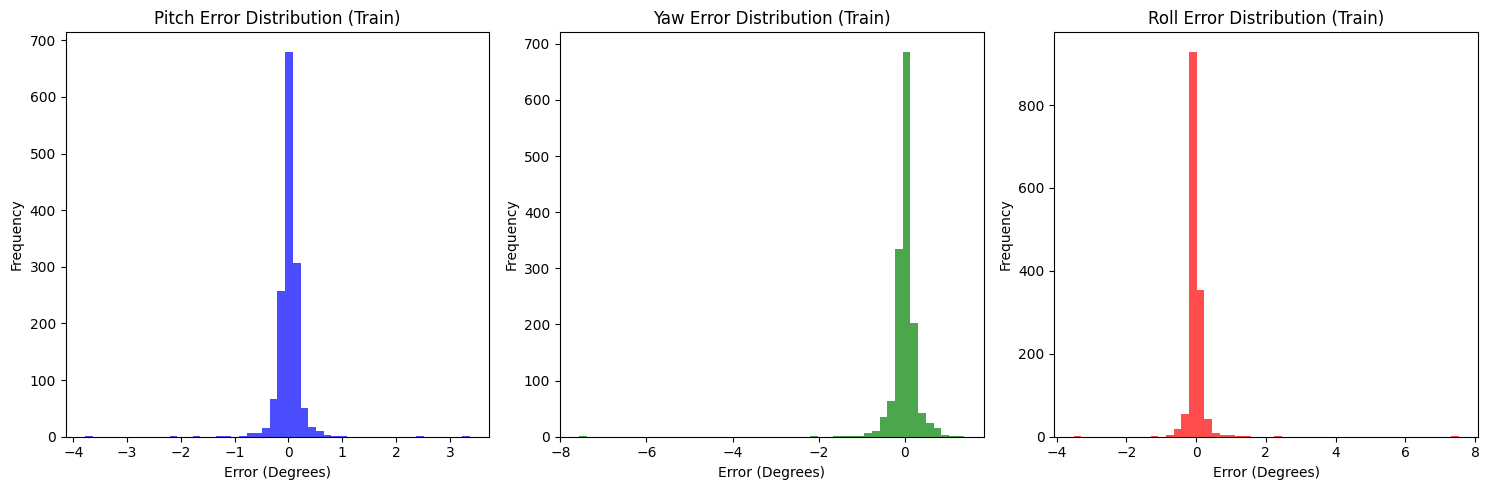

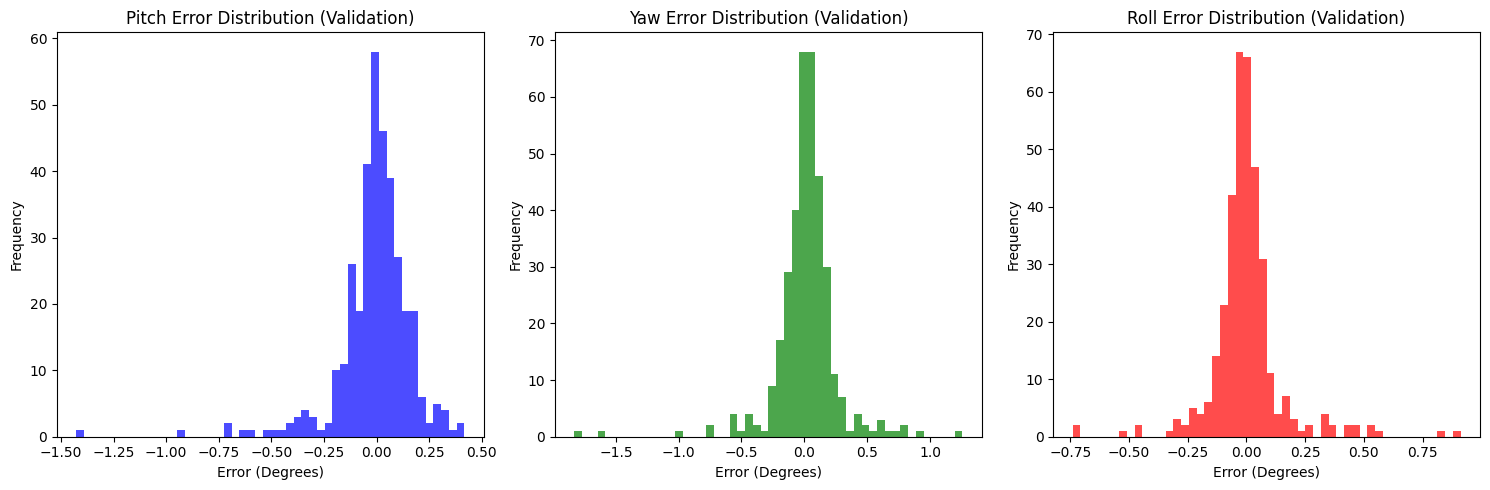

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error # Import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Build the deep learning model (simple feedforward neural network)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))  # 3 outputs for pitch, yaw, and roll

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Calculate RMSE for training and validation data
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print('Train RMSE: ', train_rmse)
print('Validation RMSE: ', val_rmse)

# Calculate additional evaluation metrics: MAE, MSE, Angular Error
train_mae = mean_absolute_error(y_train, train_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

# Calculate Angular Error (in radians)
def angular_error(true_angles, predicted_angles):
    true_angles_rad = np.deg2rad(true_angles)
    predicted_angles_rad = np.deg2rad(predicted_angles)
    angle_diff = np.abs(true_angles_rad - predicted_angles_rad)
    angle_diff = np.minimum(angle_diff, 2 * np.pi - angle_diff)  # Wrap angle error to [-π, π]
    return np.mean(angle_diff)

train_angular_error = angular_error(y_train, train_predictions)
val_angular_error = angular_error(y_val, val_predictions)

# Output the evaluation metrics
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Train Angular Error (degrees): {np.rad2deg(train_angular_error):.4f}")
print(f"Validation Angular Error (degrees): {np.rad2deg(val_angular_error):.4f}")

# Plot error distribution (histograms)
errors_train = y_train.values - train_predictions
errors_val = y_val.values - val_predictions

# Plot histograms for the errors in pitch, yaw, and roll (Training data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(errors_train[:, 0], bins=50, color='blue', alpha=0.7, label="Train Pitch Error")
axes[0].set_title("Pitch Error Distribution (Train)")
axes[0].set_xlabel("Error (Degrees)")
axes[0].set_ylabel("Frequency")

axes[1].hist(errors_train[:, 1], bins=50, color='green', alpha=0.7, label="Train Yaw Error")
axes[1].set_title("Yaw Error Distribution (Train)")
axes[1].set_xlabel("Error (Degrees)")
axes[1].set_ylabel("Frequency")

axes[2].hist(errors_train[:, 2], bins=50, color='red', alpha=0.7, label="Train Roll Error")
axes[2].set_title("Roll Error Distribution (Train)")
axes[2].set_xlabel("Error (Degrees)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot for pitch, yaw, and roll errors (Validation data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(errors_val[:, 0], bins=50, color='blue', alpha=0.7, label="Validation Pitch Error")
axes[0].set_title("Pitch Error Distribution (Validation)")
axes[0].set_xlabel("Error (Degrees)")
axes[0].set_ylabel("Frequency")

axes[1].hist(errors_val[:, 1], bins=50, color='green', alpha=0.7, label="Validation Yaw Error")
axes[1].set_title("Yaw Error Distribution (Validation)")
axes[1].set_xlabel("Error (Degrees)")
axes[1].set_ylabel("Frequency")

axes[2].hist(errors_val[:, 2], bins=50, color='red', alpha=0.7, label="Validation Roll Error")
axes[2].set_title("Roll Error Distribution (Validation)")
axes[2].set_xlabel("Error (Degrees)")
axes[2].set_ylabel("Frequency")
plt.savefig('/content/plot_errors_validation_fnn.png', bbox_inches='tight')

plt.tight_layout()
plt.show()

# CNN Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2704 - val_loss: 0.0978
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 - val_loss: 0.0721
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1504 - val_loss: 0.0629
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774 - val_loss: 0.0502
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1329 - val_loss: 0.0474
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1823 - val_loss: 0.0460
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0666 - val_loss: 0.0412
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 - val_loss: 0.0386
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0572 - val_loss: 0.0382
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - val_loss: 0.0378
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528 - val_loss: 0.0371
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - val_l

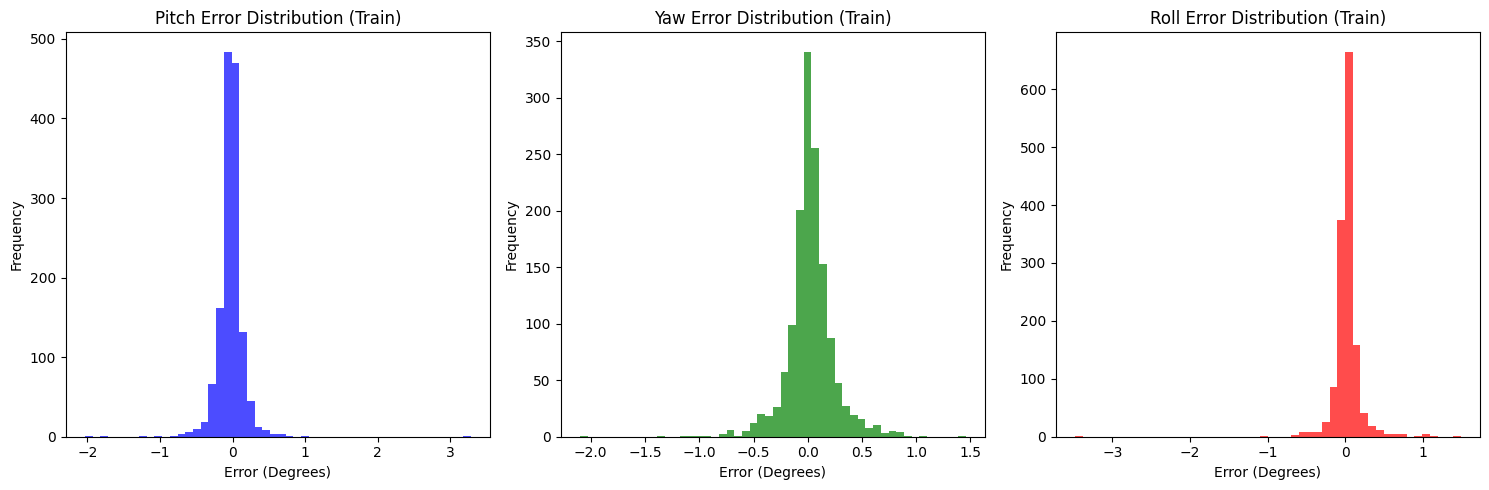

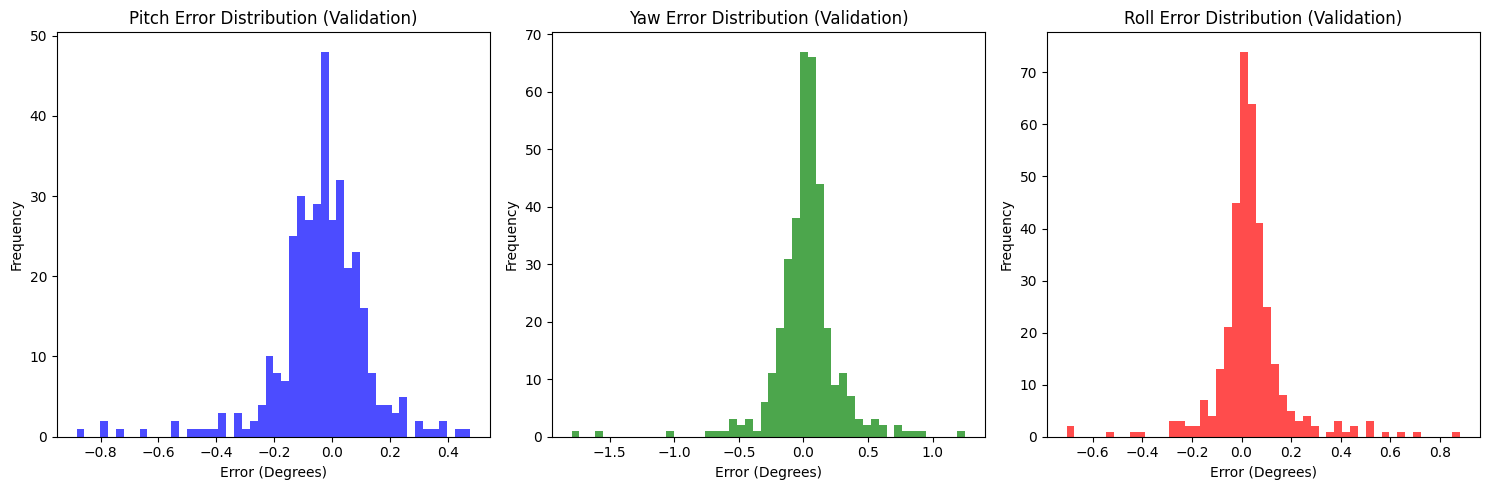

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Assuming 'poses_df' is already preprocessed and normalized

# Split the dataset into train and validation sets
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)

X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]

# Reshape the data for CNN (treating landmarks as a 2D grid)
X_train_reshaped = X_train.values.reshape(-1, 14, 1, 1)  # 14 landmarks, 1 coordinate, 1 channel
X_val_reshaped = X_val.values.reshape(-1, 14, 1, 1)      # Same reshaping for validation set

# Build the CNN model
model_cnn = Sequential()

# First convolutional layer
model_cnn.add(Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(14, 1, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 1)))  # Max pooling to reduce spatial dimensions

# Second convolutional layer
model_cnn.add(Conv2D(64, kernel_size=(3, 1), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 1)))  # Max pooling to further reduce dimensions

# Flatten the output for fully connected layers
model_cnn.add(Flatten())

# Fully connected layers for regression
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))

# Output layer for pitch, yaw, and roll (regression task)
model_cnn.add(Dense(3, activation='linear'))  # 3 outputs for pitch, yaw, and roll

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model_cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)

# Evaluate the model
train_predictions = model_cnn.predict(X_train_reshaped)
val_predictions = model_cnn.predict(X_val_reshaped)

# Calculate RMSE for training and validation data
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate MAE for training and validation data
train_mae = mean_absolute_error(y_train, train_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)

# Calculate MSE for training and validation data
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

# Calculate Angular Error (in radians)
def angular_error(true_angles, predicted_angles):
    true_angles_rad = np.deg2rad(true_angles)
    predicted_angles_rad = np.deg2rad(predicted_angles)
    angle_diff = np.abs(true_angles_rad - predicted_angles_rad)
    angle_diff = np.minimum(angle_diff, 2 * np.pi - angle_diff)  # Wrap angle error to [-π, π]
    return np.mean(angle_diff)

train_angular_error = angular_error(y_train, train_predictions)
val_angular_error = angular_error(y_val, val_predictions)

# Output the results
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Train Angular Error (degrees): {np.rad2deg(train_angular_error):.4f}")
print(f"Validation Angular Error (degrees): {np.rad2deg(val_angular_error):.4f}")

# Plot error distribution (histograms)
errors_train = y_train.values - train_predictions
errors_val = y_val.values - val_predictions

# Plot histograms for the errors in pitch, yaw, and roll (Training data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(errors_train[:, 0], bins=50, color='blue', alpha=0.7, label="Train Pitch Error")
axes[0].set_title("Pitch Error Distribution (Train)")
axes[0].set_xlabel("Error (Degrees)")
axes[0].set_ylabel("Frequency")

axes[1].hist(errors_train[:, 1], bins=50, color='green', alpha=0.7, label="Train Yaw Error")
axes[1].set_title("Yaw Error Distribution (Train)")
axes[1].set_xlabel("Error (Degrees)")
axes[1].set_ylabel("Frequency")

axes[2].hist(errors_train[:, 2], bins=50, color='red', alpha=0.7, label="Train Roll Error")
axes[2].set_title("Roll Error Distribution (Train)")
axes[2].set_xlabel("Error (Degrees)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()

# Save the plot as an image file
plt.savefig('/content/plot_errors_train.png', bbox_inches='tight')

# Show the plot
plt.show()

# Plot for pitch, yaw, and roll errors (Validation data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(errors_val[:, 0], bins=50, color='blue', alpha=0.7, label="Validation Pitch Error")
axes[0].set_title("Pitch Error Distribution (Validation)")
axes[0].set_xlabel("Error (Degrees)")
axes[0].set_ylabel("Frequency")

axes[1].hist(errors_val[:, 1], bins=50, color='green', alpha=0.7, label="Validation Yaw Error")
axes[1].set_title("Yaw Error Distribution (Validation)")
axes[1].set_xlabel("Error (Degrees)")
axes[1].set_ylabel("Frequency")

axes[2].hist(errors_val[:, 2], bins=50, color='red', alpha=0.7, label="Validation Roll Error")
axes[2].set_title("Roll Error Distribution (Validation)")
axes[2].set_xlabel("Error (Degrees)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()

# Save the plot as an image file
plt.savefig('/content/plot_errors_validation_cnn.png', bbox_inches='tight')

# Show the plot
plt.show()



# Testing


In [ ]:
pickle.dump(model, open('./model_fnn.pkl', 'wb'))

In [ ]:
pickle.dump(model_cnn, open('./model_Cnn.pkl', 'wb'))


In [ ]:
model1 = pickle.load(open('/content/model_fnn.pkl', 'rb'))
model1

<Sequential name=sequential, built=True>

In [ ]:
model2 = pickle.load(open('/content/model_Cnn.pkl', 'rb'))
model2

<Sequential name=sequential_1, built=True>

In [ ]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)

In [ ]:
def normalize(poses_df):
    normalized_df = poses_df.copy()

    for dim in ['x', 'y']:
        # Centerning around the nose
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]


        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff

    return normalized_df

In [ ]:
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    yaw = -yaw
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty

    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    return new_img

Image shape:  (450, 450, 3)
targets:  [ 0.01718213 -0.50427365 -0.575389  ]


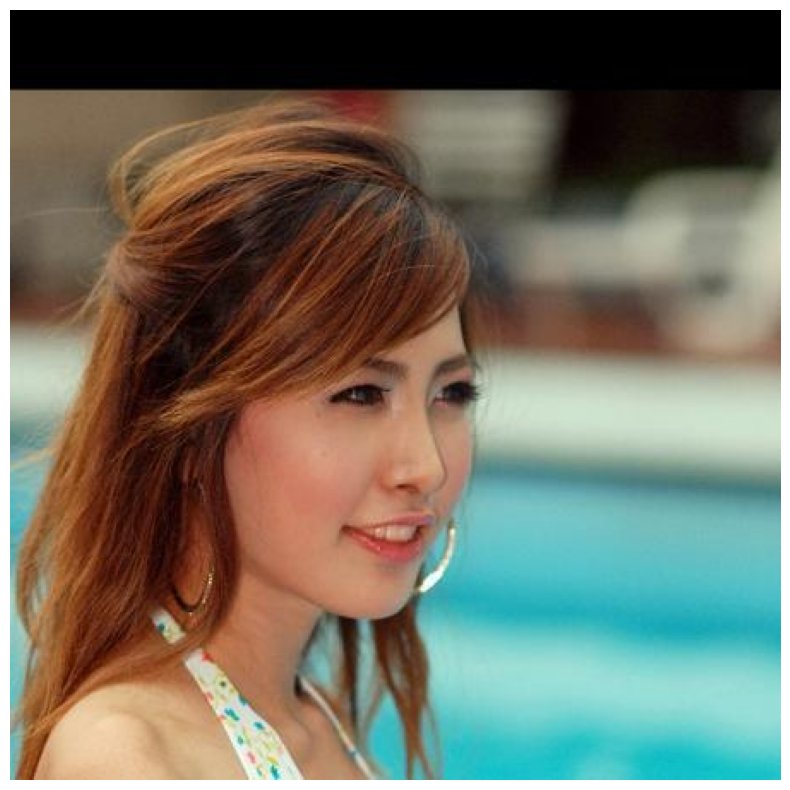

In [ ]:
import glob
DEMO_IMG_NUMBER = 115
images_paths = glob.glob('/content/drive/MyDrive/AFLW2000-3D/AFLW2000/*.jpg')
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

img_info_paths = glob.glob('/content/drive/MyDrive/AFLW2000-3D/AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
print('targets: ', mat['Pose_Para'][0][:3].ravel())

In [ ]:
def extract_features(img, face_mesh):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291

    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)

    return face_features

In [ ]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_features = extract_features(img, face_mesh)
face_features_df = pd.DataFrame([face_features], columns=cols)
face_features_normalized = normalize(face_features_df)
pitch_pred, yaw_pred, roll_pred = model1.predict(face_features_normalized).ravel()
print('predictions: ', pitch_pred, yaw_pred, roll_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions:  -0.18503428 -0.762378 0.29939443


In [ ]:
import numpy as np

# ... (previous code) ...

face_features2 = extract_features(img, face_mesh)
face_features_df2 = pd.DataFrame([face_features], columns=cols)
face_features_normalized2 = normalize(face_features_df)

# Reshape the input data to match the expected shape of the model
face_features_normalized2 = face_features_normalized2.values.reshape(1, 14, 1, 1)

pitch_pred2, yaw_pred2, roll_pred2 = model2.predict(face_features_normalized2).ravel()
print('predictions: ', pitch_pred2, yaw_pred2, roll_pred2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predictions:  -0.39750022 -0.71997684 0.37381262


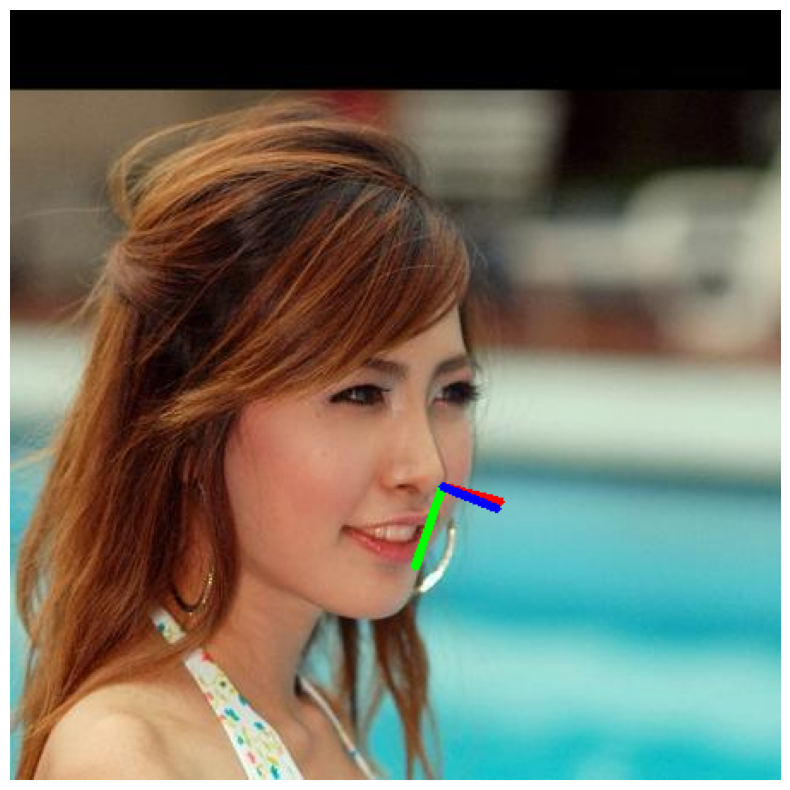

In [ ]:
img_h, img_w, img_c = img.shape
nose_x = face_features_df['nose_x'].values * img_w
nose_y = face_features_df['nose_y'].values * img_h

new_img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

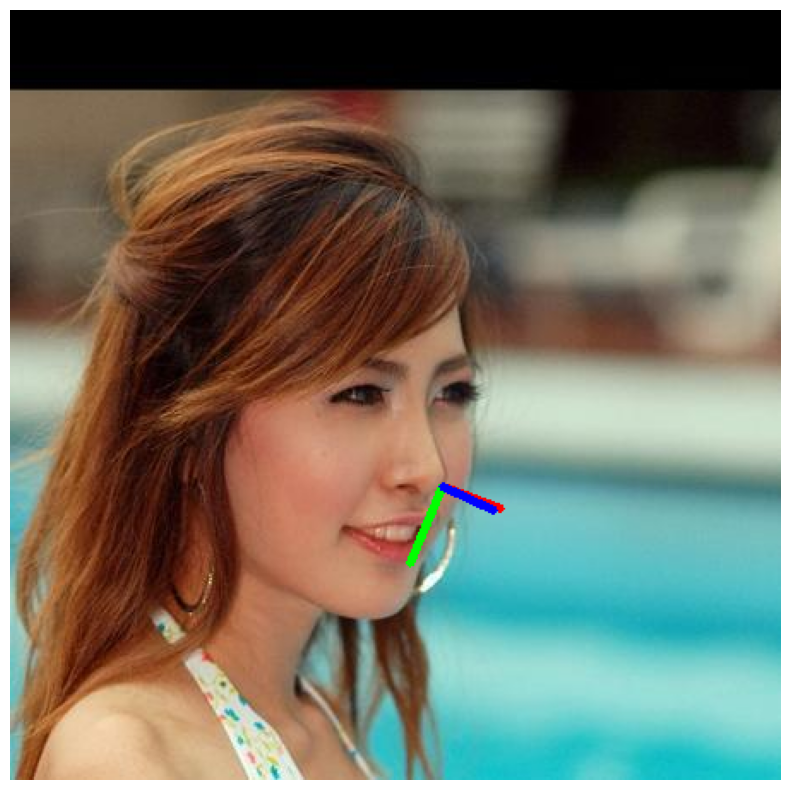

In [ ]:
img_h, img_w, img_c = img.shape
nose_x2 = face_features_df2['nose_x'].values * img_w
nose_y2 = face_features_df2['nose_y'].values * img_h

new_img2= draw_axes(img, pitch_pred, yaw_pred2, roll_pred2, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img2);